<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#코인판-크롤러-프로그램" data-toc-modified-id="코인판-크롤러-프로그램-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>코인판 크롤러 프로그램</a></span><ul class="toc-item"><li><span><a href="#크롤링-프로그램" data-toc-modified-id="크롤링-프로그램-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>크롤링 프로그램</a></span></li></ul></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DBSCAN</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LDA</a></span></li></ul></div>

# 코인판 크롤러 프로그램

해당 프로그램은 2022년 11월에 제작됐으며, 향후 코인판 홈페이지의 개편이나 보안 강화가 이뤄질 경우, 해당 프로그램이 작동되지 않을 수 있습니다.

In [1]:
#module import 

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt

okt = Okt()

In [2]:
#setting plt font & size

plt.rcParams["font.family"] = "Hancom MalangMalang"
plt.rcParams['figure.figsize'] = 10,10
sns.set(font="Hancom MalangMalang", rc={"axes.unicode_minus":False}, style='white')

In [26]:
#definate function

def word_counter(value, key_words):
    for i in value:
        if i not in key_words:
            key_words[i] = 1 #최초 언어
        elif i in key_words:
            key_words[i] += 1 #중복 언어
    return key_words


def no_space(text):
    a = re.sub("\n", "", text)
    b = re.sub("  ", "", a)
    c = re.sub("[0-9]+ ", "", b)
    return c


def tokenizer(text):
    lis = []
    for i in text:
        word = okt.nouns(i) #토큰화
        for k in word:
            lis.append(k)
    return lis


def counter_to_DataFrame(key_words):
    word_df = pd.DataFrame(key_words.items()) #Data Frame 형성
    word_df.columns = ['단어', '빈도']
    word_df = word_df.sort_values(['빈도'],ascending = False).reset_index(drop = True) #내림차순 정렬
    return word_df


## 크롤링 프로그램
하단의 프로그램을 통해 코인판의 내용을 크롤링 할 수 있습니다

In [38]:
iter = 10   #몇 페이지까지 크롤링 할 것인지?

In [77]:
key_words = {}
word_lis = []
words = []

driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(5)

url = 'https://coinpan.com/index.php?mid=free&page=1'
driver.get(url)


for i in range(3, iter + 3):
        
    #딜레이 생성
    seed = np.random.randint(100)
    np.random.seed(seed)
    a = np.random.randint(5)
    time.sleep(a)
    
    for j in range(6,26):
        title = driver.find_element_by_css_selector(f'table > tbody > tr:nth-child({j}) > td.title > a')
        noun = title.get_attribute('text')
        k = no_space(noun)
        words.append(k)
    token = tokenizer(words)
    word_lis.append(words)
    key_words = word_counter(token, key_words) #Counter Dict 형성
    
    if i <= 7:
        driver.find_element_by_xpath(f'//*[@id="view_198_0"]/div[2]/div/ul/li[{i}]/a').click()
        time.sleep(3)
    else : 
        driver.find_element_by_xpath(f'//*[@id="view_198_0"]/div[2]/div/ul/li[8]/a').click()
        time.sleep(3)

driver.quit()

In [82]:
df = counter_to_DataFrame(key_words) #Data Frame으로 변환
df = df[df['단어'].str.len() > 1]
df.reset_index(drop=True, inplace=True)

In [83]:
 top_df = df.head(30) #상위 20개 단어 추출

<AxesSubplot:xlabel='빈도', ylabel='단어'>

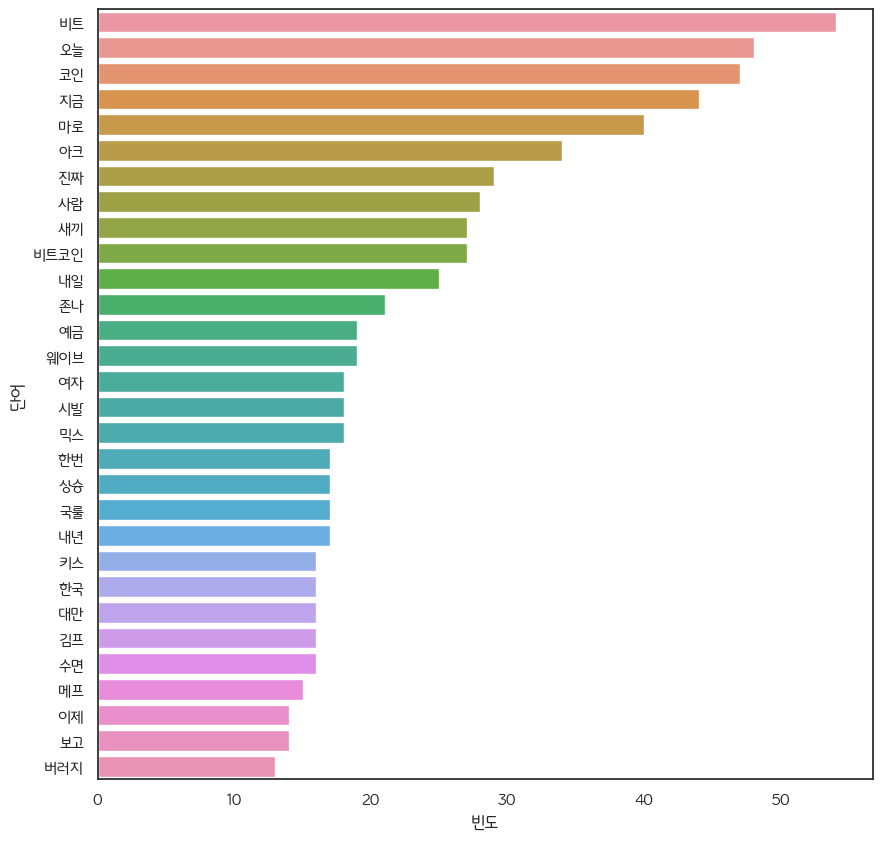

In [84]:
sns.barplot(data = top_df, x = '빈도', y = '단어')

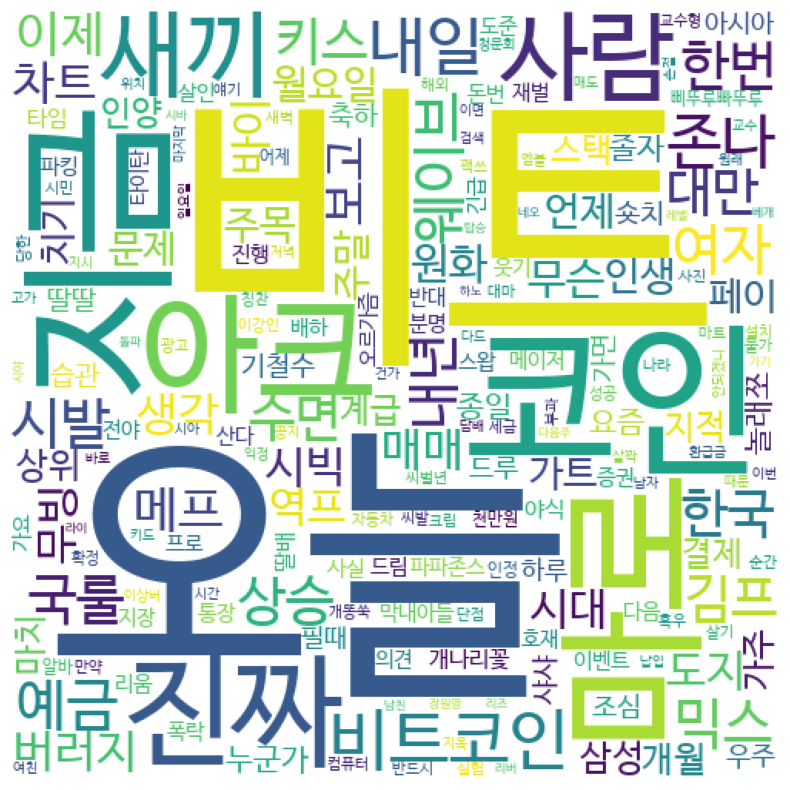

In [85]:
#WordCloud 형성
wc = WordCloud(font_path = 'C:\\Users\\cjsso\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf', #폰트 위치(사용자에 맞게 설정)
    width = 500,
    height = 500,
    background_color='white').generate_from_frequencies(df.set_index('단어').to_dict()['빈도'])


plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# DBSCAN

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

text = word_lis[0]

text_df = pd.DataFrame(text, columns=['문서'])

In [177]:
tfidf = TfidfVectorizer()
tfidf.fit(text)
vector = tfidf.transform(text).toarray()

tfidfvector = np.array(vector)

In [191]:
dbs = DBSCAN(eps=0.9,min_samples=2, metric = "cosine") 
cluster = dbs.fit_predict(tfidfvector)
text_df['군집'] = cluster

print('군집개수 :', cluster.max())

군집개수 : 23


# K-means

In [194]:
inertias = []
for k in range(1,20):
    K_means = KMeans(n_clusters=k)
    K_means.fit(tfidfvector)
    inertias.append(K_means.inertia_)

c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\s

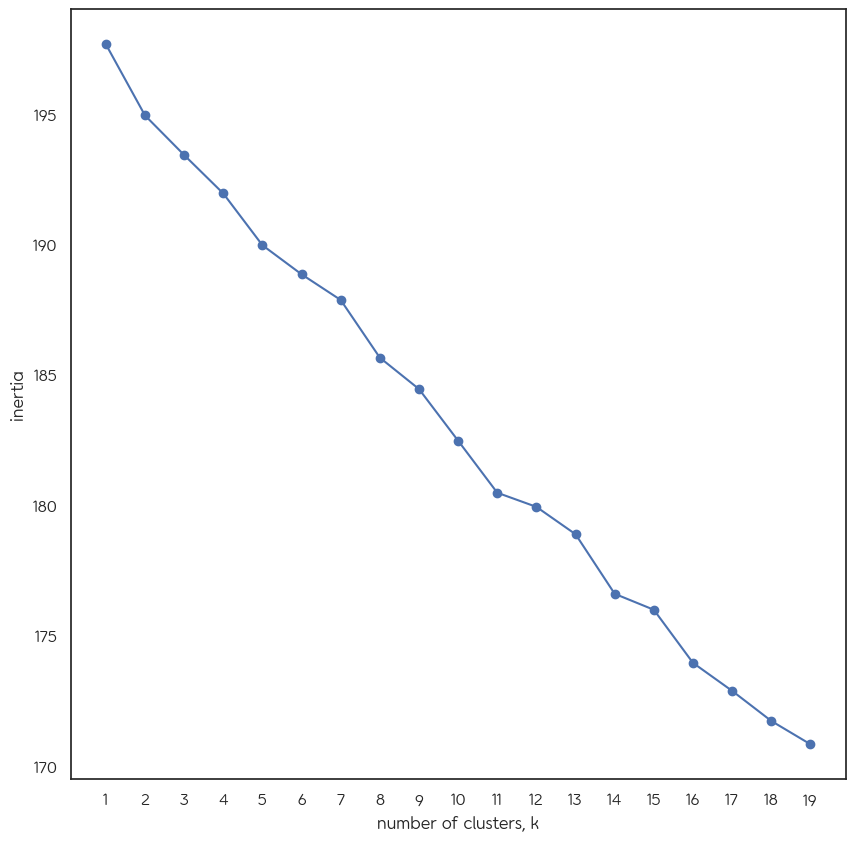

In [195]:
x = range(1,20)

plt.plot(x, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(x)
plt.show()

완만해지는 구간 X
</br>
최적 토픽 x

In [ ]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = k, random_state = 10)

k_means.fit(tfidfvector)

# LDA

In [ ]:
for lis in word_lis:
    for i in lis:
        if not len(i) > 1:
            lis.remove(i)
    while '이미지' in lis:
        lis.remove('이미지')
    while '첨부' in lis:
        lis.remove('첨부')

In [23]:
from gensim import corpora
coin_dict = corpora.Dictionary(word_lis)
corpus = [coin_dict.doc2bow(text) for text in word_lis]

In [24]:
import gensim

perplexity = []
for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    perplexity.append(ldamodel.log_perplexity(corpus))

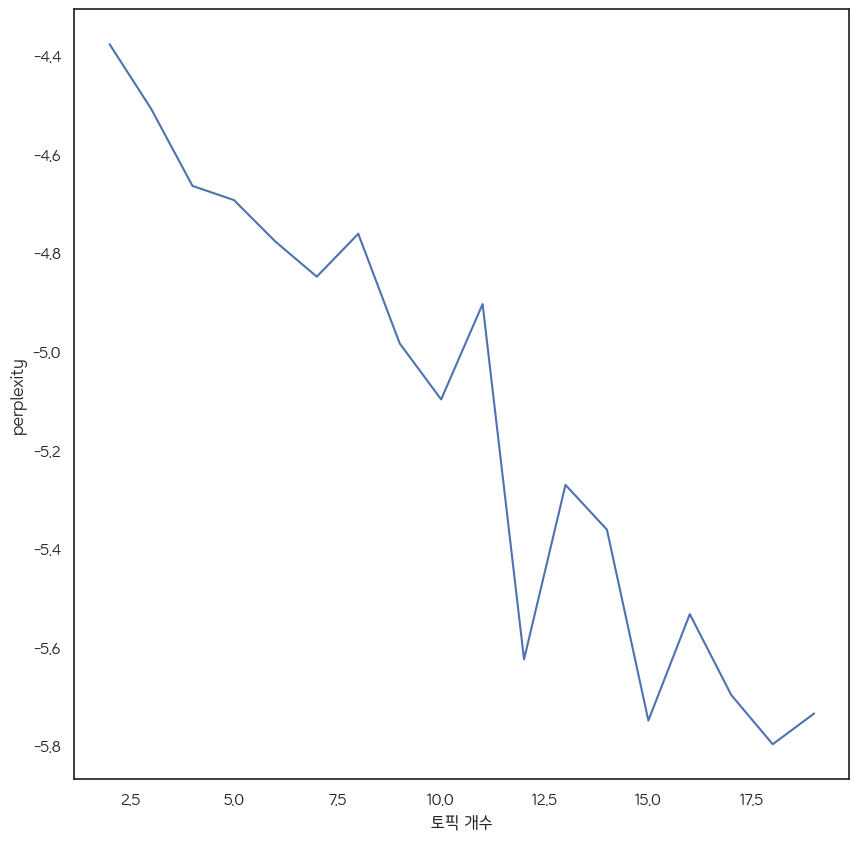

In [25]:
x = range(2,20)
plt.plot(x,perplexity)
plt.xlabel("토픽 개수")
plt.ylabel("perplexity")
plt.show()

In [26]:
from gensim.models import CoherenceModel

coherence = []
for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    coherence_mo_lda = CoherenceModel(model = ldamodel, texts = word_lis, dictionary = coin_dict, topn=10) 
    coherence_lda = coherence_mo_lda.get_coherence()
    coherence.append(coherence_lda)

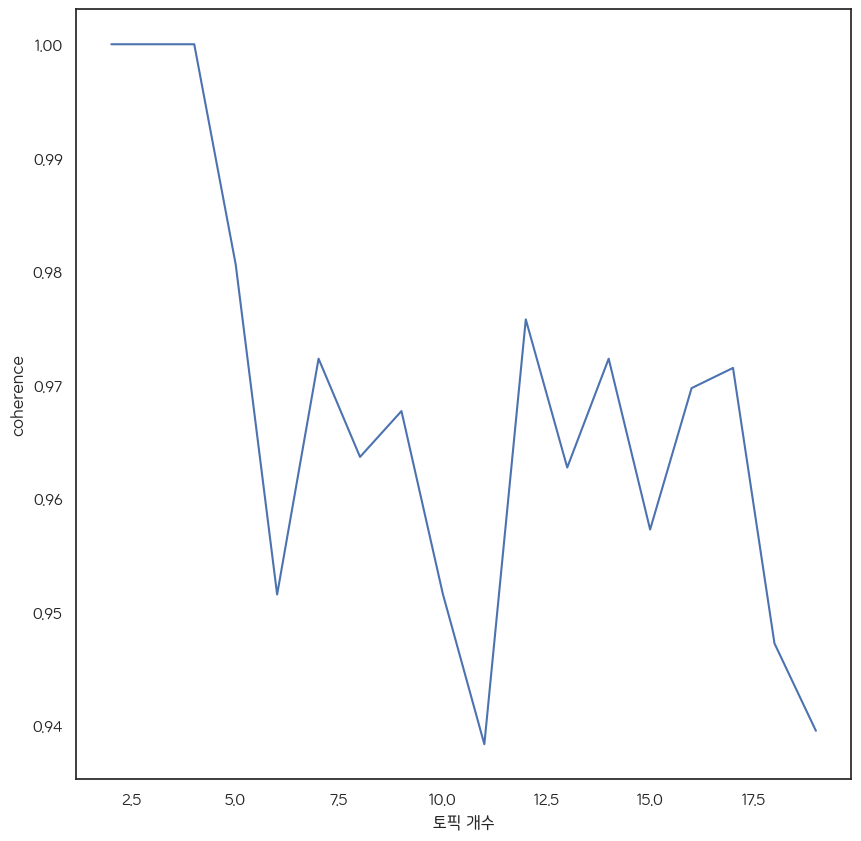

In [27]:
x = range(2,20)
plt.plot(x,coherence)
plt.xlabel("토픽 개수")
plt.ylabel("coherence")
plt.show()

In [28]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=coin_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.043*"드라마" + 0.031*"비트" + 0.031*"나이" + 0.016*"교차" + 0.016*"시드"')
(1, '0.017*"드라마" + 0.016*"비트" + 0.016*"나이" + 0.016*"평생" + 0.016*"진짜"')
(2, '0.017*"드라마" + 0.017*"나이" + 0.016*"과세" + 0.016*"메인" + 0.016*"알트"')


In [29]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, coin_dict, mds='mmds')
pyLDAvis.display(vis)

c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [30]:
pyLDAvis.save_html(vis, 'coinpan_LDA.html') #LDAvis save